# Abstract

Physics-based computer models are used to predict the behavior of complex physical systems.  It is also common to use observations of the physical system to solve the inverse problem, i.e. to learn about the values of parameters within the model, a process often called calibration. In order to make appropriate use of observations of the physical system it is important to recognize model  discrepancy, the difference between reality and the model output.  

# 1. Introduction

Acknowledging that “essentially all models are wrong” \cite{BoxHunterHunter}, a fundamental question for engineering practice is “What is the desired level of fidelity required by the model?”\cite{Shulking}. Mechanistic computer models are critical to elucidating the underlying phenomena of experimental data and to make predictions outside the measurable world. In chemical engineering, the standard practice is to construct mechanistic models from detailed system knowledge, such as reaction kinetics, thermodynamics, transport phenomena, and stream compositions. Process data is, in turn, leveraged to infer the parameters within the computer model in a process called calibration. However, computational tractability constraints demand simplifications and approximations that induce uncertainty in the predictive model. Additionally, when the underlying phenomena are not known a-priori, misspecified (i.e., incorrect) models can result in predictions that systematically differ from reality. Thus, uncertainty quantification is essential for providing reliable computer model predictions.

Model  discrepancy  was  formally  introduced  as  a  source  of  uncertainty  in  simulator  predictions by Kennedy and O’Hagan (KOH) (2001), who referred to it as model inadequacy. They considered the problem of using observations of the real physical system to learn about uncertain input parameters, a process usually known as calibration, and showed how to account for model discrepancy in calibration and in subsequent predictions of  the  physical  system. In chemical engineerig




Although model calibration is typically employed to improve the predictive performance of misspecified models, estimating the physically-meaningful parameters may also have an intrinsic scientific value. In statistics, identifiability is a property a model must satisfy for precise parameter inference to be achievable. Moreover, a model is said to be identifiable if realizing the actual values of its parameters is theoretically possible \cite{someone}. Although technically well-defined with informative priors, the traditional KOH calibration framework is generally unidentifiable. To see the identifiability issue, consider two sets of estimates $(\hat{\boldsymbol{\theta}}_1, \hat{\delta}_1)$ and $(\hat{\boldsymbol{\theta}}_2, \hat{\delta_2})$ and write $\hat{\delta}_1 = \zeta - \eta(\matr{x}, \hat{\boldsymbol{\theta}}_1)$ and  $\hat{\delta}_2 = \zeta - \eta(\matr{x}, \hat{\boldsymbol{\theta}}_2)$. As both sets of parameters yield the same distribution for $\zeta$, $(\boldsymbol{\theta}, \delta)$ are not identifiable. Furthermore, there are multiple sets of  $(\hat{\boldsymbol{\theta}}, \hat{\delta})$ that fit the data equally well. Pragmatically, this identifiability issue prohibits meaningful uncertainty quantification of the parameters without prior information.


Recently, parameter estimation with the KOH model has gained attention in chemical engineering \cite{mesbah, Galvanin}. Although the identifiability issue of KOH models is a well-known problem in the uncertainty quantification community \cite{icelandic last name, add other people}, the discussion is limited in chemical engineering. Moreover, chemical engineering literature recognizes two approaches to tackling this problem: (i) carefully defining the parameter priors based on extensive knowledge of the problem physics \cite{Bayarri et al, Liu et al., 2009} and (ii) choosing functions that are less flexible than a GP \cite{Joseph, Xiong, Fani review paper}. A third less explored option is to separate the calibration process into multiple steps, often called sequential calibration \cite{10.1615/Int.J.UncertaintyQuantification.2023044543}. Recently, \citeauthor{Storlie JRSSB} provided one such framework utilizing a two-step frequentist approach \cite{Storlie JRSSB}. In step one, least squares regression provides an estimate for $\boldsymbol{\theta}$. In step two, the least squares estimate $\hat{\boldsymbol{\theta}}$ separates the noisy discrepancy into $\{\delta +\epsilon, y - \eta{\matr{x}, \hat{\boldsymbol{\theta}}}$, from which $\delta$ is recoverable with any nonparametric approach. If model misspecification is not severe, i.e., the physical meaning of $\boldsymbol{\theta}$ holds in $\eta(\cdot,\cdot)$, this framework is practical for parameter estimation.


# 2. Methods

## 2.1 Bayesian Calibration of Computer Models - Kennedy & O'Hagan (2001)

The goal of calibration is to find a set of model parameter values that best reproduce the reality of experimental data. In 2001, statisticians Kennedy and O’Hagan \cite{KOH2001} developed a framework for Bayesian calibration of misspecified computer models. In this framework, an output $y$ from the physical system $\zeta$ is observed with measurement error $\epsilon$ for $n$ independent experimental controls $\mathbf{x} = [x_1,\dots, x_D ] \in \chi$, i.e., $y_i = \zeta(\mathbf{x}_i) + \epsilon_i, i=1,\dots, n$. The physical reality $\zeta(\mathbf{x})$ can be approximated by a mechanistic (computer) model $\eta(\mathbf{x},\boldsymbol{\theta})$ where $\boldsymbol{\theta} = [\theta_1,\dots,\theta_P]$ is a vector of physically meaningful parameters. There can also be a model discrepancy function that accounts for bias in the misspecified model. Therefore, the model for the experimental data is
$$y = \eta(\mathbf{x}, \boldsymbol{\theta}) + \delta(\mathbf{x}) + \epsilon,$$

where $\delta$ is the bias between the true processs $\zeta$ and the computer model $\eta$. The goal is to estimate the physically meaningful parameters $\boldsymbol{\theta}$ and those of the discrepancy function $\delta$, which is typically done in a Bayesian framework \cite{Higdon2004}.

## 2.2 Gaussian Process Semi-Parametric Regression - He & Severini (2016)

Consider the semi-parametric KOH model $y = \eta(\mathbf{x}_i, \boldsymbol{\theta}) + \delta(\mathbf{x}_i) + \epsilon_i$, where $\epsilon_1,\dots,\epsilon_n$ are independent normal random variables each with mean 0 and variance $\sigma_\epsilon^2$. Gaussian process (GP) regression is based on modeling $\delta$ as a Gaussian process with a mean function 0 and a covariance function $K_\phi(\cdot,\cdot)$, where, for each $\phi$, $K_\phi$ is a real-valued function on $\chi \times \chi$ and $\phi \in \Phi$ is an unknown parameter vector. The function $\delta$ and the measurement error $\epsilon$ are assumed to be uncorrelated.

Under the GP distribution, $[\delta(\mathbf{x}_1),\dots,\delta(\mathbf{x}_n)] ^\intercal$ follows a multivariate distribution with a mean vector $\mathbf{0}$ and a covariance matrix based on

$$\text{Cov}(\delta(\mathbf{x}_j), \delta(\mathbf{x}_k)) = K_\phi(\mathbf{x}_j,\mathbf{x}_k), \quad j,k = 1,\dots,n.$$


It is important to understand that the properties of $K_\phi(\cdot,\cdot)$ are chosen to reflect the assumptions regarding the function $\delta(\cdot)$. Suppose that $\chi \subseteq \mathbb{R}$. Then we generally assume that the covariance of $\delta(\mathbf{x})$ and $\delta(\mathbf{x}')$ is a decreasing function of $\vert\mathbf{x} -\mathbf{x}' \vert $. Specifically, take the scaled Gaussian correlation function:

$$K_\phi(\mathbf{x},\mathbf{x}')=\sigma_\delta^2 \exp\left(- \left(\frac{\vert \vert \mathbf{x} - \mathbf{x}' \vert \vert}{\psi} \right)^2 \right), \quad \phi = [\sigma_\delta^2,\psi].$$

The variance $\sigma_\delta^2$ expresses a prior belief that $\delta(x)$ is not likely to be outside the range $\pm 2 \sigma_\delta$, so it measures the strength of prior information about $\delta(x)$. The fact that the variance is the same for all $\mathbf{x}$ implies that we do not have a prior expectation that $|\delta(\mathbf{x})|$ is likely to take larger values for some $\mathbf{x}$ values than for others.  The correlation function (exponential component) expresses a prior belief that $\delta(\mathbf{x})$ will be a smooth function, with the value of $\delta(\mathbf{x}_1)$ being close to that of $\delta(\mathbf{x}_2)$ if $\mathbf{x}_1$ is close to $\mathbf{x}_2$. The parameter $\psi$ determines how far apart $\mathbf{x}_1$ and $\mathbf{x}_2$ need to be before $\delta(\mathbf{x}_1)$ can be very different from $\delta(\mathbf{x}_2)$.

The marginal distribution of $\mathbf{y}=[y_1,\dots,y_n]^\intercal$ is multivariate normal with mean vector $[\eta(\mathbf{x}_1,\boldsymbol{\theta}),\dots,\eta(\mathbf{x}_n,\boldsymbol{\theta})]^\intercal$ and a covariance matrix
$\Sigma_\phi + \sigma_\epsilon^2\mathbf{I}$, where $\mathbf{I}$ is the $n \times n$ identity matrix and $\Sigma_\phi$ is the $n\times n$ matrix with $(j,k)$th element given by the equation above. Thus, the log-likelihood function for $\omega = [\phi^\intercal,\sigma_\epsilon^2]^\intercal$ is

$$\ell(\omega) = -\frac{1}{2} \log \vert \mathbb{V}(\omega)\vert -\frac{1}{2} [\mathbf{y} - \eta(\mathbf{x}, \boldsymbol{\theta})]^\intercal \mathbb{V}(\omega)^{-1} [\mathbf{y} - \eta(\mathbf{x}, \boldsymbol{\theta})],$$

where $\mathbb{V}(\omega) = \Sigma_\phi + \sigma_\epsilon^2 \mathbf{I}$.

For $\mathbf{x}^* \in \chi$, the conditional expected value of $\zeta(\mathbf{x}^*) = \eta(\mathbf{x}^*, \boldsymbol{\theta}) + \delta(\mathbf{x}^*)$ given the data is $\Sigma_\phi^*(\Sigma_\phi +\sigma_\epsilon^2\mathbf{I})^{-1}(\mathbf{y} - \eta(\mathbf{x},\boldsymbol{\theta}))$ where $\Sigma_\phi^*$ is the $1 \times n$ matrix representing the covariance matrix of $\zeta(\mathbf{x}^*)$ and $[\zeta(\mathbf{x}_1),\dots,\zeta(\mathbf{x}_n)] ^\intercal$. As $\mathbf{x}^∗$ varies, this expression yields the Gaussian process regression estimator of $\zeta$, with any unknown parameters replaced by estimators. 

## 2.3 Estimation as Optimization

For simplicity, consider the case when the independent variables have dimension $D=1$. Additionally, assume the misspecified model is linear in parameters, i.e., $\eta(\mathbf{x},\boldsymbol{\theta}) = X \boldsymbol{\theta}, X \in \mathbb{R}^{n\times p}$.  Estimation for a given value of the parameters $\omega$ can be carried out by using generalized least-squares, leading to the estimator

$$\hat{\boldsymbol{\theta}}(\omega)=(X^\intercal \mathbb{V}(\omega)^{-1} X)^{−1}X^\intercal \mathbb{V}(\omega)^{−1}\boldsymbol{y}.$$

Of course, $\omega$ is generally unknown and must be estimated. The maximum likelihood estimator of $\omega$ can be obtained by maximizing the log-likelihood for $\omega$, based on the integrated likelihood, and given by

$$\ell(\omega) = -\frac{1}{2} \log \vert \mathbb{V}(\omega)\vert -\frac{1}{2} [\mathbf{y} - X\hat{\boldsymbol{\theta}}(\omega)]^\intercal \mathbb{V}(\omega)^{-1} [\mathbf{y} - X \hat{\boldsymbol{\theta}}(\omega)].$$

Let $x^∗$ denote an element of $\chi$ and consider estimation of the unknown function $\zeta$ evaluated at $x^∗, \zeta(x^∗)$. If the parameters are known, the best linear predictor of $\zeta(x^∗)$ is given by 

$$\mathbb{E}_{\zeta \vert \hat{\omega}}[\zeta(x^*)] = \Sigma_{\hat{\phi}}^{∗} \mathbb{V}(\hat{\omega})^{−1}[\mathbf{y}−X\hat{\theta}]$$

where $\hat{\boldsymbol{\theta}} = \boldsymbol{\theta}(\hat{\omega})$.

We can write this estimation problem as an unconstrained nested optimization problem. Because we are estimating the parameters, our optimization "parameters" are the regressors $X$ and observations $\boldsymbol{y}$. The "decision variables" are the model parameters $\sigma_\epsilon^2, \sigma_\delta^2, \psi\in \mathbb{R}_+$ where we write $\phi = [\sigma_\delta^2,\psi]^\intercal$ and $\omega = [\phi^\intercal, \sigma_\epsilon^2]^\intercal$. Our goal is to optimize the nuissance parameters $\omega$ using the log-likelihood function of generalized least sqaures estimator. This is written as:
$\DeclareMathOperator*{\argmin}{arg\,min}$
\begin{equation}
\begin{aligned}
\argmin_{\omega \in \Omega} \quad & \frac{1}{2} \log \vert \mathbb{V}(\omega)\vert + \frac{1}{2} [\mathbf{y} - X\hat{\boldsymbol{\theta}}(\omega)]^\intercal \mathbb{V}(\omega)^{-1} [\mathbf{y} - X \hat{\boldsymbol{\theta}}(\omega)],\\
\textrm{s.t.} \quad & \hat{\boldsymbol{\theta}}(\omega)=(X^\intercal \mathbb{V}(\omega)^{-1} X)^{−1}X^\intercal \mathbb{V}(\omega)^{−1}\boldsymbol{y},\\
& \omega = [\phi^\intercal, \sigma_\epsilon^2], \phi = [\sigma_\delta^2,\psi]^\intercal, \\
& \sigma_\epsilon^2, \sigma_\delta^2, \psi\in \mathbb{R}_+.
\end{aligned}
\end{equation}

# 3. Motivating Example (Results & Discussion)


## 3.1 The Simple Machine  -  Brynjarsdóttir & O’Hagan (2014)

Imagine a machine where the amount of work delivered depends on the amount of effort put into it.  Our somewhat naive simulator for this machine is that work is proportional to effort, i.e.,

$$\eta(x, \theta) = \theta x$$

where $x$ is effort and $\theta$ is the efficiency of the machine. The parameter $\theta$ is unknown and our interest is in both learning about $\theta$ and then using this model to predict work for a given amount of effort. This simulator has obvious deficiencies in that any losses in efficiency (e.g., due to friction) are not accounted for.  We therefore have model-discrepancy that needs to be acknowledged and dealt with.

We produce synthetic experimental data by simulating, with random error, from the true process,

$$\zeta(x) = \frac{\theta x}{1 + x/a}$$

where $\theta=0.65$ and $a=20$. 

Our computer model is simple, yet it is a sensible model for the process. The $\theta$ parameter in the Simple Machine $\eta$ is the same physical parameter as in true process $\zeta$. That is, for small $x$ the true process is roughly $\theta x$ and $\theta$ is the gradient of the true process at zero. It is the theoretical efficiency of the machine, and as such it is a physical parameter that is of intrinsic interest to the machine’s designers. We will act as though we do not know the true process exactly.  We only use the synthetic dataset and the more vague information about the discrepancy between $\zeta(x)$ and $\eta(x,\theta)$ that “losses are not accounted for”.

In [1]:
import numpy as np
from numpy import ma
from scipy import stats, linalg, optimize
from matplotlib import ticker, cm
import matplotlib.pyplot as plt

## 3.2 Functions

In [12]:
def true_process(x):
    ''' Ground truth model
    
    Arguments:
        x - inputs variables, float or np.array
    
    Returns:
        ζ - ground truth model evaluates at x, float or np.array
    '''
    
    ζ = 0.65*x/(1 + x/20)
    
    return ζ

def sq_exp(x1, x2, ϕ):
    '''Computes the covariance matrix with the squared exponential kernel function
    
    Agruments:
        x1 - co-variates, n1-dimensional np.array
        x2 - co-variates, n2-dimensional np.array
        ϕ - variance of model and length scale, 2x1 np.array
    
    Returns:
        Σ - covariance matrix, nxn np.array
        
    Additional Notes:
        The squared exponential kernel k(x1,x2) is computed by k(x1,x2) = σ^2 exp(-((x1-x2)/ψ)^2)
    '''
    
    # initialize covariance matrix
    n1 = len(x1)
    n2 = len(x2)
    Σ = np.zeros([n1,n2])
    
    # unpack hyperparameters
    σsq, ψ = ϕ
    
    # build covariance
    for i in range(n1):
        for j in range(n2):
            Σ[i,j] = σsq*np.exp(-((x1[i] - x2[j])/ψ)**2)
    
    return Σ

def gls_est(X, y, Σ):
    
    ''' Computes the generalized least sqaures (gls) estimator for data (X,y) and covariance Σ
    
    Arguments:
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        Σ - covariance matrix, nxn np.array
    
    Returns:
        θ_hat - generalized least sqaures estimator, px1 np.array
        
    Additional Notes:
        The gls estimator is computed by θ_hat = (X^T Σ^-1 y)^-1 (X^T Σ^-1 y)
    '''
    
    # Solve linear system z = Σy for z to get Σ^-1 y 
    z = np.linalg.solve(Σ, y)

    # Solve linear system W = ΣX for W to get Σ^-1 X 
    W = np.linalg.solve(Σ, X)
    
    # transpose matrix of regressors
    XT = np.transpose(X)

    # compute first term: X^T Σ^-1 X
    term1 = np.dot(XT, W)

    # compute second term: X^T Σ^-1 y
    term2 = np.dot(XT, z)

    # compute gls estimator (X^T Σ^-1 y)^-1 (X^T Σ^-1 y)
    θ_hat = np.linalg.solve(term1, term2)

    return θ_hat


def ssr_cholesky(X, y, Σ, θ_hat):
    '''Computes the weighted sum of squared residuals (SSR) with Cholesky decomposition
    
    Arguments:
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        Σ - covariance matrix, nxn np.array
        θ_hat - generalized least sqaures estimator, px1 np.array
    
    Returns:
        ssr - weighted sum of squared residuald
    
    Additional Notes:
        The sum of squared residuals in matrix notation is given by (y - Xθ_hat)^T Σ^-1 (y - Xθ_hat).
        Cholesky factorization of Σ yields Σ = L^T L.
    '''
    
    # compute residuals (y - Xθ_hat)
    resd =  y - np.dot(X, θ_hat)
    
    # Cholesky facorization, Σ = L^T L
    L, lower = linalg.cho_factor(Σ, lower = True)
    
    # Cholesky decomposition 1, r = L^-1 (y - Xθ_hat)
    r = linalg.solve(L, resd)
    
    # compute ssr
    ssr = np.dot(np.transpose(r), r)
    
    return ssr

def log_like(ω, X, y):
    '''Computes the negative log-likelihood of the a linear model assuming iid Normal observation error
    
    Arguments:
        ω - variance of discrepancy model σδsq, observation error  σϵsq, and lengthscale ψ, 3x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
    
    Returns:
        ℓ - log-likelihood, float
    '''
    
    # unpack parameters
    σδsq, σϵsq, ψ = ω
    
    # build discrepancy covariance
    Σ_ϕ = sq_exp(X[:,0], X[:,0], [σδsq, ψ])
    
    # build total covariance
    Σ = Σ_ϕ + σϵsq*np.identity(len(X[:,0]))

    # compute generalized least squares estimator
    θ_hat = gls_est(X, y, Σ)

    # compute weight sum of sqaured residuals with cholesky decomposition
    ssr = ssr_cholesky(X, y, Σ, θ_hat)
    
    # compute negtaive log-likelihood
    ℓ = 1/2*np.log(abs(np.linalg.det(Σ))) + 1/2*ssr
    
    return ℓ

def gp_predict(ω, X, y, x_star):
    
    ''' Predicts ground truth model ̂ζ with point estimates of GP
    
    Arguments:
        σsq - variance of discrepancy model σδsq and observation error  σϵsq, 2x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        x_star - predictors, npx1 np.array
    
    Returns:
        ζ_star - predicted ground truth model, npx1 np.array
    '''
    
    ## build covariance matrix
    
    # unpack parameters
    σδsq, σϵsq, ψ = ω
    
    # build observations covariance
    Σxx = sq_exp(X[:,0], X[:,0], [σδsq, ψ]) + σϵsq*np.identity(len(X[:,0]))
    
    # get ols estimate
    θ = gls_est(X, y, Σxx)
    
    # build off-diagonals
    Σxx_star = sq_exp(X[:,0], x_star, [σδsq, ψ])
    Σx_starx = np.transpose(Σxx_star)
    
    # build prediction variance
    Σx_starx_star = sq_exp(x_star, x_star, [σδsq,ψ])
    
    ## compute conditional mean
    
    # cholesky factorization
    L, lower = linalg.cho_factor(Σxx, True)
    
    # solve linear system 1
    α = linalg.solve(L, y - np.dot(X,θ))
    
    # solve linear system 2
    β = linalg.solve(np.transpose(L), α)
    
    # conditional mean
    μ_star = x_star*θ + np.dot(Σx_starx, β)
    
    ## compute conditional covariance
    
    # solve linear system
    γ = linalg.solve(L, Σxx_star)
    
    # compute covariance matrix
    Σ_star = Σx_starx_star - np.dot(np.transpose(γ), γ)
    
    return μ_star, Σ_star

## 3.3 Synthetic data generation

In [13]:
## generate synthetic data

# set seed for reproducibility
np.random.seed(234)

# select independent variables
x = np.linspace(0, 10, 20)

# compute ground truth model
ζ = true_process(x)

# set ground truth variance of noise
σϵsq_tru = 0.1

# generate i.i.d. normal measurement error, ϵ_1 ,..., ϵ_n ~iid N(0,σϵsq_tru)
ϵ = stats.norm.rvs(loc = 0, scale = np.sqrt(σϵsq_tru), size = len(x))

# generate observations
y = ζ + ϵ

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

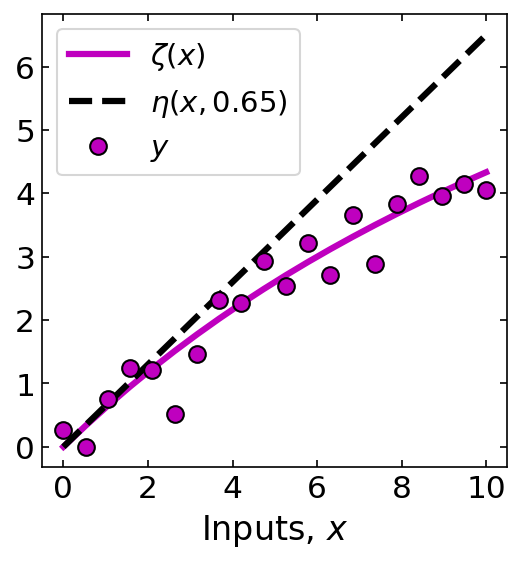

In [14]:
# choose parameter(s) of misspecified model η(x,θ)
θ = np.array([0.65])

# build nxp matrix of regressors
X = np.tile(x,len(θ)).reshape(len(x),len(θ))

# visualize misspecified model fit to data
plt.figure(figsize = (4,4), dpi = 150)

# plot groud truth mode
plt.plot(x, ζ,'m-', linewidth = 3, label = r'$\zeta(x)$')

# plot misspecified model
plt.plot(x, np.dot(X,θ),'k--', linewidth = 3, label = r'$\eta(x,0.65)$')

# plot data
plt.plot(x, y, 'mo', markeredgecolor = 'k', markersize = 8, label = r'$y$')

# other plotting parameters
plt.xlabel('Inputs, '+r'$x$', fontsize = 16)
plt.legend(fontsize = 14)
plt.tick_params(axis = 'both', top = True, right = True, direction = 'in')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

## 3.4 Optimization

In [22]:
### Set bounds and initial values for parameter estimation as optimization

## variance of discrepancy
# lower bound
σδsq_lo = 0.1
# upper bound
σδsq_hi = 2
# inital guess
σδsq_0 = 1

## variance of noise
# lower bound
σϵsq_lo = 0.01
# upper bound
σϵsq_hi = 2
# inital guess
σϵsq_0 = 1

## length scale hyperparameter
# lower bound
ψ_lo = 0.1
# upper bound
ψ_hi = 4
# inital guess
ψ_0 = 2

## concatenate bounds and inital guesses
# bounds
bds = [(σδsq_lo, σδsq_hi),(σϵsq_lo, σϵsq_hi),(ψ_lo, ψ_hi)]
# inital guesses
ω_0 = [σδsq_0, σϵsq_0, ψ_0]

In [16]:
# run scipy optimizer
results = optimize.minimize(log_like, x0 = ω_0, args = (X, y), bounds = bds)
results

      fun: -4.9060314795288456
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.77818297e+01, -3.55271368e-07, -2.97609050e-02])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 64
      nit: 11
     njev: 16
   status: 0
  success: True
        x: array([0.1       , 0.22294022, 4.        ])

## 3.5 Estimation & Prediction

In [17]:
# unpack results of optimizations
ω = results.x

# predict outside training data
x_star = np.linspace(0,15,15)
μ, Σ = gp_predict(ω, X, y, x_star)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

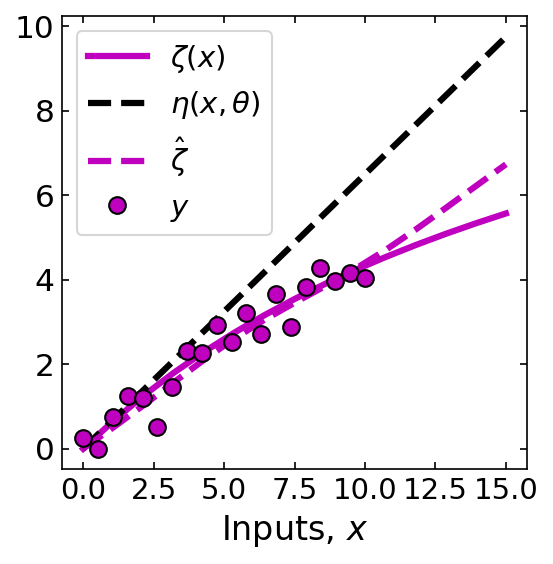

In [18]:
# visualize misspecified model fit to data
plt.figure(figsize = (4,4), dpi = 150)

# plot ground truth model
plt.plot(x_star, true_process(x_star),'m-', linewidth = 3, label = r'$\zeta(x)$')

# plot misspecified model         
plt.plot(x_star, x_star*θ,'k--', linewidth = 3, label = r'$\eta(x,\theta)$')

# plot predictions
plt.plot(x_star, μ, 'm--', linewidth = 3, label = r'$\hat{\zeta}$')

# plot data
plt.plot(x, y,'mo', markersize = 8, markeredgecolor = 'k', label = r'$y$')

# other plotting parameters
plt.xlabel('Inputs, '+r'$x$', fontsize = 16)
plt.legend(fontsize = 14)
plt.tick_params(axis = 'both', top = True, right = True, direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 15)

## 3.6 Analysis

We can see visually that the corrected model captures the missing physics much better than the misspecified model. Although the corrected model outperforms 

In [19]:
σδsq = np.arange(σδsq_lo, σδsq_hi, 0.05)
σϵsq = np.arange(σϵsq_lo, σϵsq_hi, 0.05)
var1, var2 = np.meshgrid(σδsq, σϵsq)

In [20]:
#ℓ = np.array([log_like([a,b,ω[2]], X ,y) for a, b in zip(np.ravel(var1), np.ravel(var2))]).reshape(var1.shape)

In [ ]:
# fig, ax = plt.subplots(dpi = 300)
# cs = ax.contourf(var1, var2, ℓ,  locator = ticker.LogLocator(),  cmap = cm.PuBu_r)
# cbar = fig.colorbar(cs)
# ax.set_xlabel('variance of discrepancy, '+r'$\sigma_\delta^2$', fontsize = 16)
# ax.set_ylabel('variance of noise, '+r'$\sigma_\epsilon^2$', fontsize = 16)

#ax.set_zlabel('Negative Log-Likelihood', fontsize = 16)
#ax.plot(ω[0], ω[1],log_like(ω,X,y),'k*', markersize = 8)
#fig.colorbar(cs ,label = 'Negative Log-Likelihood')

# 4. Conclusions